<a href="https://colab.research.google.com/github/tirals88/Numerical-Mathematics-and-Computing/blob/main/Chap8_More%20on%20Linear%20Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

%matplotlib inline

# 8.1 테일러 급수법

편미분방정식을 포함한 응용분야에서는 Sparse matrix를 가지는 큰 선형 시스템이 등장한다.

가우스 소거법은 0인 성분들을 0이 아닌 값들로 채울 수 있는 반면, 반복법은 행렬의 희박 구조를 보존한다.

## LU 분해

먼저 $n \times n$ 선형 연립방정식은 $Ax = b$ 형태를 가지며, 이 때 계수 행렬 A 는 다음의 형태를 가진다.

\begin{equation}
A = \left[ \begin{array}{}
a_{11} & a_{12} & a_{13} & \dots & a_{1n} \\
a_{21} & a_{22} & a_{23} & \dots & a_{2n} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
a_{n1} & a_{n2} & a_{n3} & \dots & a_{nn}
\end{array} \right]
\end{equation}

$A$에 순수 가우스 알고리즘을 적용함으로써 $A$를 단순한 두 행렬의 곱으로 분해할 수 있다.


\begin{equation}
L = \left[ \begin{array}{}
1 &  &  &  &  \\
l_{21} & 1 &  &  &  \\
l_{31} & l_{32} & 1 &  &  \\
\vdots & \vdots & \vdots & \ddots &  \\
l_{n1} & l_{n2} & l_{n3} & \dots & 1
\end{array} \right],
U = \left[ \begin{array}{}
u_{11} & u_{12} & u_{13} & \dots & u_{1n} \\
 & u_{22} & u_{23} & \dots & u_{2n} \\
 &  & u_{33} & \dots & u_{3n} \\
 & &  & \ddots & \vdots \\
 &  &  &  & u_{nn}
\end{array} \right]
\end{equation}

$LU$분해를 하기 위해 전진 소거 과정을 거치고 이 과정에서 여러 개의 $M$ 하삼각행렬을 얻게 된다.

$A$를 상삼각행렬로 만들기 위해 여러 개의 $M$을 곱하게 되면 다음의 식을 얻게 된다.

$$M_{3}M_{2}M_{1}Ax = M_{3}M_{2}M_{1}b$$

이제 전진 소거 과정이 완료되었으며 $M = M_{3}M_{2}M_{1}$을 통해 $LU$분해를 얻을 수 있다.

추가로 $LU$ 분해 구조는 알고리즘에서 0으로 나누는 경우가 없다는 점에 의존한다.
LU 분해를 수행하는 코드로 Doolittle factorization 이 있다.


In [2]:
# Doolittle factorization
def Doolittle(Arr):
  arrL = np.zeros_like(Arr)
  arrU = np.zeros_like(Arr)
  n = Arr.shape[0]
  for i in range(n):
    arrL[i, i] = 1
    for j in range(i, n):
      if i > 0:
        arrU[i, j] = Arr[i, j] - np.dot(arrL[i, :i], arrU[:i, j])
      if i==0:
        arrU[i, j] = Arr[i, j]

    for k in range(i+1, n):
      if i > 0:
        arrL[k, i] = (Arr[k, i] - np.dot(arrL[k, :i], arrU[:i, i])) / arrU[i, i]

      if i==0:
        arrL[k, i] = Arr[k, i]/arrU[i,i]
    #print('i = ', i, '\n', arrL, '\n', arrU)
  return arrL, arrU

tempa = np.array([[6, -2, 2, 4], [12, -8, 6, 10], [3, -13, 9, 3], [-6, 4, 1, -18]]).astype(np.float32)
[tempaL, tempaU] = Doolittle(tempa)
print(tempaL)
print(tempaU)
print(np.dot(tempaL, tempaU) == tempa)

[[ 1.   0.   0.   0. ]
 [ 2.   1.   0.   0. ]
 [ 0.5  3.   1.   0. ]
 [-1.  -0.5  2.   1. ]]
[[ 6. -2.  2.  4.]
 [ 0. -4.  2.  2.]
 [ 0.  0.  2. -5.]
 [ 0.  0.  0. -3.]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


$A$의 $LU$ 분해를 얻을 수 있다면, 시스템 $Ax = b$를 다음과 같이 써서 풀 수 있다.

$$LUx = b$$
위 식은 다시 다음과 같이 변형된다.

\begin{equation}
\begin{cases}
Lz = b\\
Ux = z
\end{cases}
\end{equation}

이 방법은 삼각 시스템을 푸는 것이기 때문에 더 간단하다.

이 둘을 풀기 위해 다음과 같은 코드를 만들 수 있다.

In [3]:
# 전진 치환 유사코드
# (Unit) Lower triangular system
def Lower_tri(arrL, given_b):
  vec_z = np.zeros_like(given_b)
  vec_z[0] = given_b[0]
  for i in range(1, len(given_b)):
    vec_z[i] = given_b[i] - np.dot(arrL[i, :i], vec_z[:i])

  return vec_z

In [4]:
# 역대입 유사코드
# Upper triangular system
def Upper_tri(arrU, vec_z):
  sol_x = np.zeros_like(vec_z)
  sol_x[-1] = vec_z[-1]/arrU[-1, -1]
  for i in range(len(vec_z)-2, -1, -1):
    sol_x[i] = (vec_z[i] - np.dot(arrU[i, i+1:], sol_x[i+1:]))/arrU[i, i]

  return sol_x

In [ ]:
# solution = [3, 1, -2, 1]
tempb = np.array([16., 26., -19., -34.])
tempaz = Lower_tri(tempaL, tempb)
tempx = Upper_tri(tempaU, tempaz)
tempx

array([ 3.,  1., -2.,  1.])

## $LDL^{T}$ 분해

주어진 계수행렬 $A$가 대칭적이고, 보통의 $LU$ 분해를 가질 때, $LDL^{T}$ 분해가 수행될 수 있다.

$$LU = A = A^{T} = (LU)^{T} = U^{T}L^{T}$$

$L$은 단위 하삼각행렬이므로 역행렬을 가지며 $U = L^{-1}U^{T}L^{T}$로 쓸 수 있다. 이 식을 다시 변형시키면 다음을 얻을 수 있다.

$$U(L^{T})^{-1} = L^{-1}U^{T}$$

이 때, 좌변은 ***상삼각행렬***, 우변은 ***하삼각행렬***이므로 모두 대각행렬이 된다. 이렇게 만들어진 대각행렬을 $D$라 하면 최종적으로 다음을 얻을 수 있다.

$$A = LU = LDL^{T}$$

$D = \{d_{ii}\}$를 얻기 위해 다음의 식으로 유도할 수 있다.

\begin{eqnarray}
a_{ij} &= &\sum^{n}_{\nu = 1}\sum^{n}_{\mu = 1}{\ell_{i\nu}d_{\nu \mu}(\ell^{T})_{\mu j}} \\
&= &\sum^{n}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}}\\
&= &\sum^{min(i, j)}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}}\\
\end{eqnarray}

위 식은 $j > i$ 일 때, $\ell_{ij} = 0, \ell_{ii} = 1$ 이기 때문에 가능하다.

다시 $j \leq i$ 라 가정하자, 그러면 다음이 성립한다.

\begin{eqnarray}
a_{ij} &= &\sum^{j}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}}\\
&= &\sum^{j-1}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}} + \ell_{ij}d_{j}\ell_{j j} \\
&= &\sum^{j-1}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}} + \ell_{ij}d_{j}
\end{eqnarray}

특히, $j=i$ 라 하면, 다음을 얻는다.

\begin{eqnarray}
a_{ii} &= &\sum^{i-1}_{\nu = 1}{d_{\nu}\ell^{2}_{i \nu}} + \ell_{ii}d_{i} \\
d_{i} &= &a_{ii} - \sum^{i-1}_{\nu = 1}{d_{\nu}\ell^{2}_{i \nu}}
\end{eqnarray}


또한 $\ell_{ii} = 1$ 임을 알고 있기 때문에 앞선 식으로 $\ell_{ij}$ 를 구할 수 있다.

\begin{eqnarray}
a_{ij} &= &\sum^{j-1}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}} + \ell_{ij}d_{j} \\
&\downarrow \\
\ell_{ij} &= &[a_{ij} - \sum^{j-1}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}}] / d_{j}
\end{eqnarray}

먼저 $j = 1$ 로 놓으면 $L$ 의 첫 번째 열을 생성하는 식을 얻는다.

$$\ell_{i1} = a_{i1}/d_{1}$$

다음으로 $j = 2$로 놓으면 $L$ 의 두 번째 열을 생성하는 식을 얻는다.

$$\ell_{i2} = (a_{i2} - \ell_{i1}d_{1}\ell_{21})/d_{2}$$

In [ ]:
# LDL^T decomposition
# input Arr 또는 함수 내 temp array 들을 실수형으로 지정해줘야함
def LDL_dcomp(Arr):
  LowA = np.zeros_like(Arr).astype('float32')
  arrd = np.zeros(len(Arr)).astype('float32')
  for j in range(len(Arr)):
    LowA[j, j] = 1
    arrd[j] = Arr[j, j] - np.dot(arrd[:j], (LowA[j, :j])**2)
    for i in range(j+1, len(Arr)):
      LowA[j, i] = 0
      temp = ((Arr[i, j] - np.dot((arrd[:j]*LowA[j, :j]), LowA[i, :j])) / arrd[j])
      LowA[i, j] = temp
      #print(((Arr[i, j] - np.dot((arrd[:j]*LowA[j, :j]), LowA[i, :j])) / arrd[j]))

  return LowA, arrd

In [ ]:
tempsym = np.array([[4,3,2,1],[3,3,2,1],[2,2,2,1],[1,1,1,1]])
LDL_dcomp(tempsym)

(array([[1.        , 0.        , 0.        , 0.        ],
        [0.75      , 1.        , 0.        , 0.        ],
        [0.5       , 0.6666667 , 1.        , 0.        ],
        [0.25      , 0.33333334, 0.5       , 1.        ]], dtype=float32),
 array([4.       , 0.75     , 0.6666666, 0.5      ], dtype=float32))

$A$가 대칭행렬일 때, $LU$ 분해를 넘어, $LDL^{T}$ 분해를 할 수 있었다. 만약 $A$ 가 추가로 양의 정부호행렬, ***positive definite matrix*** 라면, 촐레스키 분해 Cholesky factorization $A = LL^{T}$ 를 갖는다.

- 대칭 양의 정부호행렬 / ***positive definite matrix*** : $\quad$ 0이 아닌 벡터 $x$ 에 대해, $ x^{T}Ax > 0$ 인 행렬

$A = LDL^{T}$ 일 때, $\widetilde{D} = D^{1/2}$ (대각 성분이 $\sqrt{d_{ii}}$ 인 대각행렬)를 정의하면, $\widetilde{L} \equiv LD^{1/2}$ 이라 할 수 있다. 그리고 다음이 성립한다.

$$A = \widetilde{L}\widetilde{L}^{T}$$

## 다수의 우변

선형 시스템을 풀 때, 다수의 우변 입력을 사용하는 경우가 많다. $B$가 다음과 같이 주어졌다고 가정하자.

\begin{eqnarray}
B &= &[b^{(1)}, b^{(2)}, \dots, b^{(m)}] \\
Ax^{(j)} & = &b^{(j)}
\end{eqnarray}

그리고 이는 간단하게 $AX = B$ 로 쓸 수 있다.

이 때의 연산 횟수는 $A$ 의 분해 과정에서 $\frac{1}{3}n^{3}$ 번, 각각의 $x^{(j)}$ 역대입 과정에서도 $n^{2}$ 번의 긴 연산이 필요하다. 전체 과정에서는 $(\frac{1}{3}n^{3} + mn^{2})$ 번의 긴 연산이 요구된다. 그렇지만 이는 각각의 시스템을 개별적으로 풀 때의 연산 횟수인 $m(\frac{1}{3}n^{3} + n^{2})$ 번보다는 훨씬 적은 수이다.

## $A^{-1}$ 계산

다수의 우변을 적용하면 역행렬을 다음과 같이 표현할 수 있다.

\begin{eqnarray}
AX &= &I \\
Ax^{(j)} & = &I^{(j)}
\end{eqnarray}

추가로 선형 시스템 $Ax=b$를 풀 때, $A^{-1}$을 계산 후에 $x = A^{-1}b$ 를 계산하는 방식은 불필요한 계산을 많이 요구하기 때문에 바람직하지 않다.

위에서 다루었던 $LU$ 분해와 치환행렬 ***permutation matrix*** 를 이용하면 더 간단한 연산들로 해를 구할 수 있다.

먼저 $PA$ 의 $LU$ 분해를 가지고 있다면, 다음과 같이 나타낼 수 있다.

\begin{eqnarray}
\begin{cases}
Ly &= &Pb \\
Ux & = &y
\end{cases}
\end{eqnarray}

# 8.2 고윳값과 고유벡터

$$Ax = \lambda x$$

- ' 도전적인 고윳값 문제에 직면한 사람에게 최고의 조언은 LAPACK 의 소프트웨어를 사용하라는 것이다. ' - 교재 431p.

## 고윳값의 성질

다음의 명제들은 임의의 정사각행렬 $A$ 에 대해서 참이다.

1. $\lambda$ 가 $A$의 고윳값이라면 임의의 다항식 $p$에 대해서 $p(\lambda)$ 는 $p(A)$ 의 고윳값이다. 특히 $\lambda^{k}$ 는 $A^{k}$ 의 고윳값이다.

2. $A$ 가 역행렬을 가지고 $\lambda$ 가 $A$의 고윳값이라면 임의의 다항식 $p$ 에 대하여 $p(\lambda)$ 은 $p(A^{-1})$의 고윳값이다. 특히 $\lambda^{-1}$ 은 $A^{-1}$ 의 고윳값이다.

3. $A$ 가 실수 행렬이자 대칭행렬이면 이 행렬의 고윳값은 실수이다.

4. $A$ 가 복소 행렬이자 헤르미트 Hermite  행렬이면 이 행렬의 고윳값은 실수이다.

5. $A$ 가 헤르미트 행렬이자 양의 정부호행렬이면 이 행렬의 고윳값은 양수이다.

6. $P$ 가 역행렬을 가지면 $A$ 와 $PAP^{-1}$ 은 동일한 특성 다항식(과 동일한 고윳값)을 가진다.

---
***Hermite matrix 란 자기 자신과 켤례 전치가 같은 복소수 정사각행렬이다. 대칭행렬의 일반화이다.***

$${\displaystyle A_{ij}={\overline {A_{ji}}}}$$

먼저 $P$ 가 역행렬을 가지고 $B = PAP^{-1}$을 만족하면 두 행렬은 서로 닮았다고 한다. 그리고 닮은 행렬들은 같은 특성방정식을 갖는다.

\begin{eqnarray}
Det(B - \lambda I) &= &Det(PAP^{-1} - \lambda I)\\
&= &Det(PAP^{-1} - P(\lambda I)P^{-1})\\
&= &Det(P(A-\lambda I)P^{-1}) \\
&= &Det(P) \cdot Det(A-\lambda I)\cdot Det(P^{-1}) \\
&= &Det(A-\lambda I)
\end{eqnarray}

또한 어떠한 유니터리 행렬 $U$ 에 대해 $B = U^{*}AU$ 이면 두 행렬은 서로 유니터리 닮음 ***unitarily similar***이라 부른다. 여기서 유니터리 행렬이란 $UU^{*}=I$ 를 만족하는 행렬 $U$ 를 말한다.

위를 통해 슈어의 정리가 도출된다.

---

### 슈어의 정리 Schur's Theorem

**모든 정사각행렬은 삼각행렬과 유니터리 닮음이다.**

슈어의 정리를 통해 도출되는 따름정리가 두 개 있다.

1. 슈어의 정리에 따라 다음과 같은 분해가 가능하다. $PAP^{-1} = T$

2. 모든 정사각 헤르미트 행렬은 대각행렬과 유니터리 닮음이다.

$n \times n$ 행렬 $A$ 의 고윳값을 찾는 대부분의 수치 방법들은 위의 유사성 변환을 결정함으로써 진행된다. 그리고 나서 한 번에 고윳값 하나씩 계산을 한 후, 수축과정 ***deflation process***를 통해 해당 고윳값을 제외하고는 $A$ 와 똑같은 고윳값을 가지는 행렬 $\widetilde{A}$ 를 생성한다.

행렬 $A$의 고윳값을 찾기 위해 이 과정을 행렬 $\widetilde{A}$ 에 원하는 만큼 반복할 수 있다. 실제로 이 전략은 조심해서 사용해야 한다. ***연속적인 고윳값이 반올림 오차에 의해 오염될 수 있기 때문이다.***

### 게르시고린의 정리 Gershgorin's Theorem

때로는 복소평면 $\mathbb{C}$ 에 놓여있는 행렬의 고윳값의 위치를 개략적인 방법으로 알아내야 할 필요가 있을 수 있다. 이러한 방법 중 가장 유명한 것이 다음의 국소화 정리 ***localization theorem*** 라고 불리는 것이다.

***게르시고린의 정리***

$n \times n$ 행렬 $A=(a_{ij})$ 의 모든 고윳값들은 복소평면에서 $n$ 개의 원반 disc $C_{i} = C_{i}(a_{ii}, r_{i})$의 합집합에 속해 있다. 여기서 $a_{ii}$는 각 원의 중심이고 반지름 $r_{i}$ 는 ${i}$ 번째 행에서 대각 성분을 제외한 성분들의 크기의 합이다.

---
$A$ 의 고윳값을 포함하는 영역은 다음과 같이 나타낼 수 있다.

$$\bigcup^{n}_{i=1}{C_{i}} = \bigcup^{n}_{i=1}{\{z \in \mathbb{C} : |z - a_{ii}| \leq r_{i}\}}$$

행렬 $A$ 와 $A^{T}$가 고윳값이 같은 특징을 활용하면 열 성분에도 게르시고린의 정리를 적용할 수 있다. 이때, 반지름은 $s_{i}$, 디스크는 $D_{i}(a_{ii}, s_{i})$ 로 표시한다.

또한, 위 두 디스크들을 이용해 $A$ 의 고윳값을 포함하는 영역을 더 제한할 수 있다.

$$(\bigcup^{n}_{i=1}{C_{i}}) \:\bigcap\: (\bigcup^{n}_{i=1}{D_{i}})$$

이를 통한 유용한 국소화 결과는 다음과 같다.

- 행렬 $A$ 에 대해 남은 $(n-k)$ 원반들과 만나지 않는 $k$ 개의 모든 게르시고린 원반들의 합집합은 정확히 $k$ 개 (중복 고려)의 $A$ 의 고윳값을 포함한다.

게르시고린의 정리를 통해 역행렬의 존재 여부 또한 알 수 있다. 만약 엄격하게 대각 성분이 지배적인 행렬 ***strictly diagonally dominant matrix*** 의 경우 $|a_{ii}| \geq r_{i} \:(,\: s_{i})$ 이므로 $0$ 은 어떠한 게르시고린 원반 안에도 존재할 수 없다. 따라서 행렬식은 $0$이 아니며 역행렬을 가진다.

예제)


\begin{equation}
A = \left[ \begin{array}{}
4-i & 2 & i \\
-1& 2i & 2 \\
1& -1 & -5
\end{array} \right]
\end{equation}

아래는 $A$ 의 게르시고린 원반을 그리고 실제 고윳값들을 표시$(\star)$한 그래프이다.

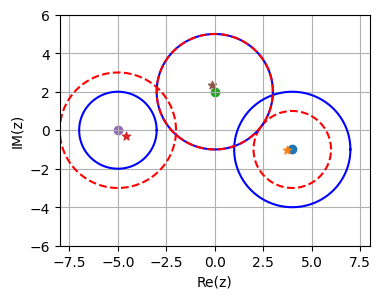

In [ ]:
def make_circle(c, r):
    theta = np.linspace(0, 2 * np.pi, 256)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.vstack((x, y)).T + c

c = np.array([[4, -1], [0, 2], [-5, 0]])


r = np.array([3, 3, 2])
s = np.array([2, 3, 3])

Gersh_c = np.array([make_circle(c[i], r[i]) for i in range(3)])
Gersh_d = np.array([make_circle(c[i], s[i]) for i in range(3)])

real_eig = np.array([[ 3.72 , -1.05 ],[-4.56 , -0.285],[-0.161,  2.34 ]])

plt.figure(figsize = (4,3))
for j in range(3):
  plt.plot(Gersh_c[j, :, 0], Gersh_c[j, :, 1], 'b-')
  plt.plot(Gersh_d[j, :, 0], Gersh_d[j, :, 1], 'r--')
  plt.scatter(c[j, 0], c[j, 1], marker='o')
  plt.scatter(real_eig[j, 0], real_eig[j, 1], marker='*')
plt.grid()
plt.xlabel('Re(z)')
plt.ylabel('IM(z)')
plt.xlim(-8, 8)
plt.ylim(-6, 6)
plt.show()

### 특이값 분해

특이값 분해 ***Singular Value Decomposition*** 은 많이 사용되는 도구로 특히 최소 제곱 문제에서 많이 사용된다. 이 분해는 정사각행렬이든 아니든 상관없이 모든 행렬에 적용할 수 있다. 행렬 $A$의 특이값이 $A^{T}A$ 의 고윳값의 음이 아닌 제곱근이라는 점에서부터 시작한다.



**행렬 스펙트럼 정리**

$A$ 가 $m \times n$ 일 때, $A^{T}A$ 는 $n \times n$ 대칭행렬이고 어떤 직교 행렬 $Q$에 의해 대각화가 가능하다. $A^{T}A = QDQ^{-1}$ 여기서 $QQ^{T} = Q^{T}Q = I, D$ 는 $n \times n$ 대각행렬이다.

이때, $A^{T}AQ = QD$ 이므로, $D$는 $A^{T}A$ 의 고윳값들로 이루어져 있으며 $Q$ 의 열은 고유벡터이다. $x$ 가 고유벡터라면, 상응하는 고윳값이 음수가 아님을 알 수 있다.

$$||Ax ||^{2} = x^{T}A^{T}Ax = x^{T}\lambda x = \lambda||x||^{2}$$

해당 고윳값들이 $\lambda_{i}$일 때, $A$ 의 특이값을 $\sigma_{j} = + \sqrt{\lambda_{j}}$ 로 정의한다.

다음으로 계산된 특이값들 중 굉장히 작은 값들은 $0$ 으로 간주할 수 있다. $0$ 이 아닌 특이값들의 개수가 $r$ 개라면 우리는 $r$ 을 수치적으로 계산한 $A$ 의 ***rank*** 라고 생각할 수 있다.

특이값 분해는 $A = UDV^{T}$ 와 같은 꼴로 표현된다. 이 때, $D$는 $d_{11} \geq d_{22} \geq \dots \geq 0$ 순으로 음이 아닌 성분으로 $A$ 의 특이값이다. 그리고 이전에 구한 고유벡터 $v_{1}, \cdots , v_{r}$ 들로 $u_{j}$ 를 얻을 수 있다.

$$u_{j} = Av_{j} / ||Av_{j}||$$

이 집합을 $\mathbb{R}^{m}$의 정규 직교 기저로 확장한다. 그리고 $V = Q$ 라 한다.

$$\sigma_{j}u_{j} = Av_{j}$$

정의된 특이값으로 조건수 ***condition number***를 표현할 수 있다.

$$\kappa(A) = \sqrt{\frac{\sigma_{max}}{\sigma_{min}}}$$

왜냐하면 $||A||^{2}_{2}= \rho(A^{T}A) = \sigma_{max}(A), \quad ||A^{-1}||^{2}_{2}= \rho(A^{-T}A^{-1}) = \sigma_{min}(A)$ 이기 때문이다.

# 8.3 누승법  Power method

누승법은 행렬의 고윳값을 계산하는 데 사용될 수 있다. 이 방법은 제대로 된 환경 하에서 주어진 행렬의 ***고윳값으로 수렴하는 수열을 생성하는 반복 과정***의 한 예이다.

먼저 $n \times n$ 행렬 $A$ 의 고윳값이 다음의 성질을 가진다고 가정한다.

$$|\lambda_{1}| > |\lambda_{2}| \geq |\lambda_{3}|  \geq \cdots \geq |\lambda_{n}|$$

그리고 각각의 고윳값은 0이 아닌 고유벡터 $u^{(i)}$를 가진다고 가정한다. 이 때, $n$ 개의 고유벡터로 이루어진 선형 독립 집합 $\{u^{(1)}, u^{(2)}, \cdots, u^{(n)}\}$ 은 $\mathbb{C}^{n}$ 의 기저이다.

---

이제 가장 큰 절댓값을 가진 단일한 고윳값(지배적인 고윳값 ***dominant eigenvalue***)과 그에 상응하는 고유벡터를 계산하려 한다. 임의의 시작 벡터 $x^{(0)} \in \mathbb{C}^{n}$ 을 선택하고 이를 고유벡터들의 선형결합으로 나타내며, $c_{1} \neq 0$ 라 가정한다.

이어서 일반성의 손실 없이***(W.L.O.G)*** 해당 상수들을 각 벡터에 흡수시킬 수 있다. 그리고 재귀적으로 $x^{(k)} = Ax^{(k-1)}$ 을 계산하여 벡터 수열을 생성할 수 있다.

\begin{eqnarray}
x^{(k)} &= &A^{k}x^{(0)} \\
&= &A^{k}u^{(1)} + A^{k}u^{(2)} + \cdots + A^{k}u^{(n)}\\
&= &\lambda^{k}_{1}u^{(1)} + \lambda^{k}_{2}u^{(2)} + \cdots + \lambda^{k}_{n}u^{(n)} \\
&= &\lambda_{1}[u^{(1)} + (\frac{\lambda_{2}}{\lambda_{1}})^{k}u^{(2)} + (\frac{\lambda_{3}}{\lambda_{1}})^{k}u^{(3)} + \cdots + (\frac{\lambda_{n}}{\lambda_{1}})^{k}u^{(n)}]
\end{eqnarray}

이 때, $\lambda_{1}$은 지배적인 고윳값이므로 $k \rightarrow \infty$ 일 때, $(\lambda_{j}/\lambda_{1})^{k} \rightarrow 0$ 을 얻는다. 이제 위 식을 단순화할 수 있다.

$$x^{(k)} = \lambda^{k}_{1}[u^{(1)} + \varepsilon^{(k)}]$$

여기서 $\varepsilon^{k} \rightarrow 0$ 이다. $\varphi$ 가 임의의 복소수 값을 가지는 $\mathbb{C}^{n}$ 의 선형 함수로 $\varphi(u^{(1)}) \neq 0$를 만족한다고 하자. 이 함수를 위 식에 적용할 수 있다.

$$\varphi(x^{(k)}) = \lambda^{k}_{1}[\varphi(u^{(1)}) + \varphi(\varepsilon^{(k)})]$$

그리고 선형 함수의 비율 $r_{k}$ 를 다음과 같이 정의한다.

$$r_{k} \equiv \frac{\varphi(x^{(k+1)}}{\varphi(x^{(k)}} = \lambda_{1}[\frac{\varphi(u^{(1)}) + \varphi(\varepsilon^{(k+1)})}{\varphi(u^{(1)}) + \varphi(\varepsilon^{(k)})}]\rightarrow \lambda_{1} \quad (k \rightarrow \infty)$$

따라서 수열 $\{r_{k}\}$ 의 수렴값을 통해 지배적인 고윳값 $\lambda_{1}$을 계산할 수 있다. 그리고 $x^{(k)}$의 계산이 거듭될수록 이에 대응되는 고유벡터로 수렴한다.

In [5]:
#Power method
def power_method(A, kmax, x, phi):
  power_df = []
  power_df.append([x, 0])
  x = x.astype('float32')
  x = x.reshape(-1, 1)
  size_n = len(A)

  for i in range(kmax):
    y = np.dot(A, x)
    if(phi(y)==0) or (phi(x)==0):
      r = 0
    else:
      r = phi(y)/phi(x)
    x = y / y.max()
    power_df.append([x.reshape(-1), r])

  power_df = pd.DataFrame(power_df)
  power_df.columns = ['eigen vector', 'eigen value']
  return power_df

test_x0 = np.array([0, 1])
test_A = np.array([[3, 1], [1, 3]])

def default_phi(temp_v):
  temp_v = temp_v.reshape(-1)
  return temp_v[0]


power_method(test_A, 8, test_x0, default_phi)

,eigen vector,eigen value
0,"[0, 1]",0.000000
1,"[0.3333333333333333, 1.0]",0.000000
2,"[0.6, 1.0]",6.000000
3,"[0.7777777777777777, 1.0]",4.666667
4,"[0.8823529411764706, 1.0]",4.285714
5,"[0.9393939393939393, 1.0]",4.133333
6,"[0.9692307692307691, 1.0]",4.064516
7,"[0.9844961240310076, 1.0]",4.031746
8,"[0.9922178988326847, 1.0]",4.015748


## 에이트켄 가속

다음의 에이트켄 가속 ***Aitken acceleration*** 공식을 통해 주어진 수열 $\{r_{k}\}$ 로부터 또 다른 수열 $\{s_{k}\}$를 만들 수 있다.

$$s_{k} = r_{k} - \frac{(r_{k} - r_{k-1})^{2}}{r_{k} - 2r_{k-1} + r_{k-2}} \quad\quad (k\geq3)$$

원래의 수열 $\{r_{k}\}$ 가 $r$로 수렴하고 특정한 조건을 만족한다면, 새로운 수열은 더 빠르게 수렴한다. 추가로 뺄셈에 의한 상쇄는 최종적으로 결과를 망칠 수 있기 때문에 에이트켄 가속 과정은 값이 명백히 변동이 없는 상태에 도달한 후 바로 멈춰야 한다.

In [38]:
#Aitken acceleration
def Aitken_acc(A, kmax, x, phi):
  x = x.astype('float32')
  temp_df = power_method(A, kmax, x, phi)
  seq_r = temp_df.iloc[:, 1]
  seq_s = np.zeros_like(seq_r).astype('float32')
  temp_s = 1
  for i in range(4, len(seq_r)):
    temp_s = seq_r[i] - ((seq_r[i] - seq_r[i-1])**2)/((seq_r[i] - 2*seq_r[i-1]+seq_r[i-2]))
    seq_s[i] = temp_s
  temp_df['eigen value(\"s\")'] = seq_s

  return temp_df

test_x0 = np.array([-1, 1, 1])
test_A = np.array([[6, 5, -5], [2, 6, -2], [2, 5, -1]])
def default_phi(temp_v):
  temp_v = temp_v.reshape(-1)
  return temp_v[1]


Aitken_acc(test_A, 20, test_x0, default_phi)

,eigen vector,eigen value,"eigen value(""s"")"
0,"[-1, 1, 1]",0.000000,0.000000
1,"[-3.0, 1.0, 1.0]",2.000000,0.000000
2,"[9.0, 1.0, 1.0]",-2.000000,0.000000
3,"[1.0, 0.4074074074074074, 0.4074074074074074]",22.000000,0.000000
4,"[1.0, 0.6049382716049384, 0.6049382716049382]",8.909091,13.529411
5,"[1.0, 0.7366255144032923, 0.736625514403292]",7.306122,7.082452
6,"[1.0, 0.8244170096021946, 0.8244170096021948]",6.715084,6.369875
7,"[1.0, 0.8829446730681298, 0.8829446730681298]",6.425957,6.149073
8,"[1.0, 0.9219631153787532, 0.9219631153787532]",6.265148,6.063620
9,"[1.0, 0.9479754102525022, 0.9479754102525021]",6.169284,6.027785


In [ ]:
Aitken_acc(test_A, 95, test_x0, default_phi).loc[80:95]

<ipython-input-38-8c84f922079e>:8: RuntimeWarning: divide by zero encountered in scalar divide
  temp_s = seq_r[i] - ((seq_r[i] - seq_r[i-1])**2)/((seq_r[i] - 2*seq_r[i-1]+seq_r[i-2]))
<ipython-input-38-8c84f922079e>:8: RuntimeWarning: invalid value encountered in scalar divide
  temp_s = seq_r[i] - ((seq_r[i] - seq_r[i-1])**2)/((seq_r[i] - 2*seq_r[i-1]+seq_r[i-2]))


,eigen vector,eigen value,"eigen value(""s"")"
80,"[1.0, 0.9999999999999836, 0.9999999999999835]",6.0,6.0
81,"[1.0, 0.9999999999999889, 0.999999999999989]",6.0,6.0
82,"[1.0, 0.9999999999999926, 0.9999999999999926]",6.0,6.0
83,"[1.0, 0.9999999999999951, 0.999999999999995]",6.0,6.0
84,"[1.0, 0.9999999999999968, 0.9999999999999968]",6.0,6.0
85,"[1.0, 0.9999999999999978, 0.9999999999999979]",6.0,6.0
86,"[1.0, 0.9999999999999986, 0.9999999999999986]",6.0,6.0
87,"[1.0, 0.999999999999999, 0.9999999999999991]",6.0,-inf
88,"[1.0, 0.9999999999999994, 0.9999999999999994]",6.0,6.0
89,"[1.0, 0.9999999999999997, 0.9999999999999999]",6.0,-inf


## 역누승법 ***inverse power method***

수정된 역누승법을 이용하면 행렬의 다른 고윳값도 계산하는 게 가능하다. 예를 들어 $A$ 가 역행렬을 가진다면 아래의 논리적 동치 조건에 주목함으로써 가장 작은 크기의 고윳값도 계산할 수 있다.

$$Ax = \lambda x ⟺ x = A^{-1}(\lambda x) ⟺ A^{-1}x = \frac{1}{\lambda} x$$

따라서 $A$ 의 가장 작은 크기의 고윳값은 $A^{-1}$의 가장 큰 고윳값의 역수이다.

여기서 우리가 구하고자 하는 것은 $A$ 의 고윳값이다. $A^{-1}$를 계산할 필요가 없다는 점을 주목한다. 따라서 다음의 두 식이 동치임을 이용한다..

\begin{eqnarray}
x^{(k+1)} &= &A^{-1}x^{k} \\
Ax^{(k+1)} &= &x^{(k)}
\end{eqnarray}

$A = LU$ 를 먼저 구해 반복적인 업데이트로 $x^{(k)}$를 얻는다.

$$Ux^{(k+1)} = L^{-1}x^{(k)}$$

In [51]:
#Inverse Power Method
def inv_power(A, kmax, x, phi):
  '''LU decomp : Doolittle'''
  [tempaL, tempaU] = Doolittle(A)
  x = x.astype('float32')
  power_df = []
  power_df.append([x, 0])
  #x = x.reshape(-1, 1)
  size_n = len(A)
  s = 0
  for i in range(kmax):
    tempaz = Lower_tri(tempaL, x)
    y = Upper_tri(tempaU, tempaz)
    if(phi(y)==0) or (phi(x)==0):
      r = 0
    else:
      r = phi(x)/phi(y)

    if np.max(np.abs(y))==0:
      x = y
    else:
      x = y / np.max(np.abs(y))
    power_df.append([x.reshape(-1), r])

  power_df = pd.DataFrame(power_df)
  power_df.columns = ['eigen vector', 'eigen value']

  seq_r = power_df.iloc[:, 1]
  seq_s = np.zeros_like(seq_r).astype('float32')
  temp_s = 1
  for i in range(4, len(seq_r)):
    temp_s = seq_r[i] - ((seq_r[i] - seq_r[i-1])**2)/((seq_r[i] - 2*seq_r[i-1]+seq_r[i-2]))
    seq_s[i] = temp_s
  power_df['eigen value(\"s\")'] = seq_s

  return power_df

temp_A = np.array([[-154, 528, 407], [55, -144, -121], [-132, 396, 318]])/3
temp_A = temp_A.astype(np.float32)
temp_x0 = np.array([1., 2., 3.])
test_inv = inv_power(temp_A, 80, temp_x0, default_phi)
test_inv

,eigen vector,eigen value,"eigen value(""s"")"
0,"[1.0, 2.0, 3.0]",0.000000,0.000000
1,"[0.77119446, -0.5458803, 1.0]",-0.013724,0.000000
2,"[-1.0, 0.41649216, -0.89587194]",-5.261705,0.000000
3,"[0.7866649, -0.5443754, 1.0]",-0.402071,0.000000
4,"[-0.9388732, 0.50695735, -1.0]",-2.393290,-1.814537
...,...,...,...
76,"[-0.8559008, 0.5274084, -1.0]",-1.277548,-1.277542
77,"[0.8559003, -0.52740854, 1.0]",-1.277537,-1.277542
78,"[-0.8559008, 0.5274084, -1.0]",-1.277548,-1.277542
79,"[0.8559003, -0.52740854, 1.0]",-1.277537,-1.277542


In [55]:
#역행렬을 power_method 를 통해 고윳값의 역수가 얻어짐을 확인할 수 있다.
power_method(np.linalg.inv(temp_A), 100, temp_x0, default_phi)

,eigen vector,eigen value
0,"[1.0, 2.0, 3.0]",0.000000
1,"[0.7711942740630766, -0.545880439587965, 1.0]",-72.875849
2,"[-2.400825266206063, 1.0, -2.150918345290104]",-0.190087
3,"[0.7866651014727366, -0.5443752655737879, 1.0]",-2.487591
4,"[-1.8519074303079883, 1.0, -1.9725225706278682]",-0.417900
...,...,...
96,"[-1.622807292100811, 1.0, -1.8960491826572923]",-0.782896
97,"[0.8558888170962252, -0.5274124791417588, 1.0]",-0.782896
98,"[-1.6228072921009271, 1.0, -1.8960491826573374]",-0.782896
99,"[0.8558888170962247, -0.5274124791417651, 1.0]",-0.782896


위 행렬의 고윳값과 고유벡터는 다음과 같다.

[ 6.04468 / 1.89942 / -1.27743 ]

(-1.85691, -1.37621, 1), (0.576768, -0.596385, 1), (0.855895, -0.52741, 1)

이 중 가장 작은 크기의 고윳값인 -1.27743 과 그에 대응되는 고유벡터에 근사하였음을 알 수 있다.

In [8]:
temp_x = test_inv.iloc[-1, 0]
Ax = np.dot(temp_A, temp_x.reshape(-1, 1))
lx = temp_x * test_inv.iloc[-1, 1]
print('Ax : ',Ax.reshape(-1))
print('rx :',lx)
print('Ax - rx : ', Ax.reshape(-1)-lx)

Ax :  [ 1.09344793 -0.67378507  1.2775429 ]
rx : [ 1.09344793 -0.67378604  1.27754106]
Ax - rx :  [-4.13002965e-14  9.68865403e-07  1.84163012e-06]


## 이동한 (역)누승법

문제에 따라 주어진 수 $\mu$ 에 가장 멀거나 가까운 고윳값을 구해야할 필요가 있다.

먼저 가장 먼 고윳값을 계산할 수 있다. 행렬 $A$ 의 한 고윳값 $\lambda_{j}$에 대해 다음이 성립한다고 가정하자.

$$|\lambda_{j} - \mu| > \epsilon, \quad 0 <|\lambda_{i} - \mu| < \epsilon \quad \quad (모든 i \neq j 에 대해)$$

이동한 행렬 $(A-\mu I)$에 누승법을 적용해서 $(\lambda_{j} - \mu)$에 수렴하는 비율 $r_{k}$를 계산한다. 이 과정이 이동한 누승법이라 불린다.

반대로 가장 가까운 $A$ 의 고윳값을 구하고자 한다면 $\lambda_{j}$ 가 다음을 만족한다고 가정할 수 있다.

$$0<|\lambda_{j} - \mu| < \epsilon, \quad |\lambda_{i} - \mu| > \epsilon \quad \quad (모든 i \neq j 에 대해)$$

비율 $r_{k}$ 가 $(\lambda_{j} - \mu)^{-1}$에 수렴하므로 다음을 얻는다.

$$\lambda_{j} = \mu + (\lim_{k \to \infty}{r_{k}})^{-1} = \mu + (\lim_{k \to \infty}{\frac{1}{r_{k}}})$$

In [9]:
#Inverse Power Method
def shifted_power(A, kmax, x, phi, mu):
  shifted_A = A - np.eye(len(A))*mu
  temp_df = power_method(shifted_A, kmax, x, phi)
  great_eig = temp_df.iloc[-1, :]

  temp_df = inv_power(shifted_A, kmax, x, phi)
  small_eig = temp_df.iloc[-1, :2]

  great_eig[1] += mu
  small_eig[1] = mu + 1/small_eig[1]
  return [great_eig, small_eig]

temp_A = np.array([[1., 3., 7.], [2., -4., 5.], [3, 4, -6]])
#temp_A = temp_A.astype(np.float32)
temp_x0 = np.array([1., 1., 1.])
test_shifted = shifted_power(temp_A, 40, temp_x0, default_phi, -6)
test_shifted

[eigen vector    [1.0, 0.4429064533028382, 0.42272450462220756]
 eigen value                                           5.287791
 Name: 40, dtype: object,
 eigen vector    [-1.0, 0.9083245892740397, 0.35801768290173874]
 eigen value                                           -5.434678
 Name: 40, dtype: object]

In [56]:
#1 -(a)

Arr_1a = np.array([[5, 4, 1, 1], [4, 5, 1, 1], [1, 1, 4, 2], [1, 1, 2, 4]])
test_x0 = np.array([1, 1, 1, 1])

power_method(Arr_1a, 20, test_x0, default_phi)

,eigen vector,eigen value
0,"[1, 1, 1, 1]",0.000000
1,"[1.0, 1.0, 0.7272727272727273, 0.7272727272727...",11.000000
2,"[1.0, 1.0, 0.608695652173913, 0.608695652173913]",10.454545
3,"[1.0, 1.0, 0.5531914893617021, 0.5531914893617...",10.217391
4,"[1.0, 1.0, 0.5263157894736843, 0.5263157894736...",10.106383
5,"[1.0, 1.0, 0.5130890052356022, 0.5130890052356...",10.052632
6,"[1.0, 1.0, 0.5065274151436031, 0.5065274151436...",10.026178
7,"[1.0, 1.0, 0.5032594524119949, 0.5032594524119...",10.013055
8,"[1.0, 1.0, 0.501628664495114, 0.501628664495114]",10.006519
9,"[1.0, 1.0, 0.5008140670791272, 0.5008140670791...",10.003257


In [58]:
test_x0 = np.array([1, 2, 3, 4])
inv_power(Arr_1a, 100, test_x0, default_phi)

,eigen vector,eigen value,"eigen value(""s"")"
0,"[1.0, 2.0, 3.0, 4.0]",0.000000,0.000000
1,"[-0.17, 0.15, 0.25, 1.0]",13.333333,0.000000
2,"[-0.262, -0.029999996, -0.25, 1.0]",-20.000004,0.000000
3,"[-0.2004, -0.07399999, -0.75, 1.0]",1.621621,0.000000
4,"[-0.082368, -0.0073599955, -1.0, 0.8]",32.173927,-72.347046
...,...,...,...
96,"[-1.0, 0.35470945, -0.37875754, 0.008016034]",3.954803,3.977672
97,"[-1.0, 0.35445547, -0.37821785, 0.007920794]",3.955307,3.976259
98,"[-1.0, 0.35420746, -0.37769082, 0.00782779]",3.955801,3.978031
99,"[-1.0, 0.3539652, -0.37717602, 0.007736945]",3.956284,3.978031


In [78]:
#7
Arr_7 = np.array([[-4, 14, 0], [-5, 13, 0], [-1, 0, 2]])
test_x0 = np.array([1, 1, 1])
inv_power(Arr_7, 10, test_x0, default_phi)

<ipython-input-51-499954598b1f>:32: RuntimeWarning: invalid value encountered in scalar divide
  temp_s = seq_r[i] - ((seq_r[i] - seq_r[i-1])**2)/((seq_r[i] - 2*seq_r[i-1]+seq_r[i-2]))


,eigen vector,eigen value,"eigen value(""s"")"
0,"[1.0, 1.0, 1.0]",0.000000,0.000000
1,"[-0.5, -0.0, 1.0]",0.000000,0.000000
2,"[-1.0, -0.30769232, 0.30769232]",0.000000,0.000000
3,"[-1.0, -0.31858405, 0.07079646]",0.444444,0.000000
4,"[-1.0, -0.31917098, 0.016580312]",0.467532,0.468798
5,"[-1.0, -0.3192032, 0.003886797]",0.468798,0.468871
6,"[-1.0, -0.31920496, 0.0009112006]",0.468867,0.468871
7,"[-1.0, -0.31920508, 0.00021361778]",0.468871,0.468871
8,"[-1.0, -0.31920508, 5.0079598e-05]",0.468871,0.468871
9,"[-1.0, -0.31920508, 1.1740437e-05]",0.468871,0.468871


In [79]:
Aitken_acc(Arr_7, 10, test_x0, default_phi)

,eigen vector,eigen value,"eigen value(""s"")"
0,"[1, 1, 1]",0.000000,0.000000
1,"[1.0, 0.8, 0.1]",8.000000,0.000000
2,"[1.0, 0.7499999999999999, -0.1111111111111111]",6.750000,0.000000
3,"[1.0, 0.7307692307692307, -0.1880341880341881]",6.333333,0.000000
4,"[1.0, 0.7222222222222223, -0.2208504801097394]",6.157895,6.030303
5,"[1.0, 0.718181818181818, -0.2359147025813692]",6.076923,6.007519
6,"[1.0, 0.716216216216216, -0.24309494679865057]",6.037975,6.001876
7,"[1.0, 0.7152466367713004, -0.24658756082107697]",6.018868,6.000469
8,"[1.0, 0.7147651006711409, -0.24830578085473554]",6.009404,6.000117
9,"[1.0, 0.7145251396648045, -0.2491565616700684]",6.004695,6.000029


In [91]:
shifted_power(Arr_7, 20, test_x0, default_phi, 5)

[eigen vector    [-0.0016013151827130234, -0.000800657018680620...
 eigen value                                              3.000014
 Name: 20, dtype: object,
 eigen vector    [1.0, 0.71428585, -0.2499996]
 eigen value                          5.999999
 Name: 20, dtype: object]

# 8.4 선형 시스템의 반복법에 의한 해

이 절에서는 ***nonsingular*** 선형 시스템 $Ax = b$를 푸는 완전히 다른 전략을 탐구한다. 이 대안적 접근방식은 수치적으로 편미분방정식을 풀 때 발생하는 거대한 문제에 종종 사용된다.

## 벡터와 행렬 노름

우선 벡터와 행렬 노름에 관한 짧은 개요를 살펴본다. 노름은 어떤 벡터 공간에서도 정의될 수 있고, 보통 $\mathbb{R}^{n}$ 또는 $\mathbb{C}^{n}$ 을 사용하며 크기 또는 길이로 생각할 수 있다. 벡터노름은 벡터가 속한 공간에서 $\mathbb{R}$로의 모든 사상 ***mapping***이다. 그리고 다음의 성질을 만족한다.

1) $||x|| > 0 \quad (\vec{x} \neq 0)\quad$ 2) 상수배 $\quad$3) 삼각부등식

벡터 $x = (x_{1}, x_{2}, \cdots, x_{n})^{T} \in \mathbb{R}^{n}$ 의 벡터 노름의 예는 다음과 같다.

\begin{eqnarray}
||x||_{1} &= &\sum^{n}_{i =1}{|x_{i}|} \quad \quad &(L_{1} \:norm)\\
||x||_{2} &= &(\sum^{n}_{i =1}{x_{i}^{2}})^{1/2} &(L_{2} \:norm)\\
||x||_{\infty} &= &\max_{1\leq i \leq n}{|x_{i}|} &(L_{\infty} \:norm)
\end{eqnarray}

$n \times n$ 행렬에 대해서도 행렬 노름을 구할 수 있다. 행렬 $A, B$와 스칼라 $\alpha$에 대해서 위와 동일한 요구조건(1, 2, 3)을 만족해야 한다.

우리는 보통 벡터 노름과 관련 있는 행렬 노름을 선호한다. 벡터 노름 $|| \cdot ||$에 대해서 종속된 행렬 노름은 다음과 같이 정의된다.

$$||A|| = \sup\{ ||Ax|| : x \in \mathbb{R}^{n}, ||x || = 1\}$$

추가적인 성질은 다음과 같다.

\begin{eqnarray}
||I|| &= &1 \\
||Ax|| &\leq &||A|| ||x|| \\
||AB || &\leq &||A|| ||B||
\end{eqnarray}

$n \times n$ 행렬 $A$에 대해 종속된 행렬 노름의 예는 다음과 같다.

\begin{eqnarray}
||A||_{1} &= &\max_{1\leq j \leq n}{\sum^{n}_{i=1}{|a_{ij}|}} \quad \quad &(L_{1} \:norm)\\
||A||_{2} &= &\max_{1\leq i \leq n}{\sqrt{|\sigma_{\max}|}} &(L_{2} \:norm)\\
||A||_{\infty} &= &\max_{1\leq i \leq n}{\sum^{n}_{j=1}{|a_{ij}|}} &(L_{\infty} \:norm)
\end{eqnarray}

## 조건수와 나쁜 조건

선형 시스템의 수치 해에 어떤 영향을 주는 중요한 양이 조건수 ***condiion number***이다. 조건수의 정의는 다음과 같다.

$$\kappa(A) = ||A||_{2}||A^{-1}||_{2}$$

조건수의 근삿값을 얻기 위해 $A$의 역행렬을 반드시 계산해야 할 필요는 없다는 것이 알려져 있다. 또한 조건수가 행렬 $A$ 와 벡터 $b$로부터 해 $x$의 이전된 오차를 측정해준다는 것을 보일 수 있다.

- 규칙 : 경험 규칙

$\kappa(A) = 10^{k}$라면 시스템 $Ax=b$를 풀 때 적어도 $k$ 자리 정확도가 상실되리라는 것을 예측할 수 있다.

선형 시스템이 $A$나 $b$ 성분의 작은 변화에 민감하다면 이 사실은 $A$ 에 반영되어서 $A$ 가 큰 조건수를 갖게 된다. 이러한 경우 행렬 $A$ 가 나쁜 조건에 있다 ***ill-conditioned***라고 말한다. 간단히 말하면 조건수가 클수록 더 심하게 나쁜 조건의 시스템이다.

주어진 선형 시스템을 풀고자 하지만 측정에서의 불확실성과 계산에서의 반올림 오차 때문에 데이터 상에 작은 변화가 생길 수 있다. 우변에 기호 $\delta b$에 해당하는 양만큼의 작은 변화가 있고 이에 상응하는 해의 변화를 기호 $\delta x$로 표기하기로 한다 그러면 다음이 성립한다.

$$A(x + \delta x) = b + \delta b$$

노름을 이용하면 다음을 얻을 수 있다.

$$\frac{1}{||x||} \leq \frac{||A||}{||b||}$$

작은 변화가 있는 선형 시스템 $A \delta x = \delta b$ 로부터 $\delta x = A^{-1}\delta b$를 얻고, 다음을 알 수 있다.

$$||\delta x|| \leq ||A^{-1}|| \:|| \delta b||$$
$$\frac{||\delta x||}{||x||} \leq \kappa(A) \frac{||\delta b||}{||b||}$$

선형 시스템을 풀 때 계수 행렬의 조건수는 데이터의 오차에 대한 시스템의 민감도를 측정해준다. 그러므로 해를 정확한 것으로 받아들이기 전에 더 많은 확인이 필요하다.

1 근처의 조건수는 좋은 조건의 행렬 ***well-conditioned matrix***, 큰 값의 조건수는 나쁜 조건의 행렬 ***ill-conditioned matrix***을 나타낸다. 행렬의 특이성 ***singularity***을 확인하는데 행렬식을 사용하는 것은 오직 행렬이 적당한 크기일 때만 적절한 방식이다.